# Part 2: Image segmentation

In [1]:
# import necessary libraries

import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2024-04-15 16:40:47.997187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 16:40:47.997313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 16:40:48.167414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Constants
_IMAGE_SHAPE = (128, 128)
_BATCH_SIZE = 64

In [6]:
# Define _fixup_shape function
def _fixup_shape(image, mask):
    image.set_shape(_IMAGE_SHAPE + (3,))  
    mask.set_shape(_IMAGE_SHAPE)          
    return image, mask

In [8]:
# Preprocessing functions
def load_image_and_mask(im_path, mask_path):
    img_raw = tf.io.read_file(im_path)
    img = tf.io.decode_image(img_raw, dtype=tf.dtypes.uint8, expand_animations=False)
    img = tf.image.resize(img, _IMAGE_SHAPE, preserve_aspect_ratio=False, antialias=True)

    mask = np.array(Image.open(mask_path.numpy()).resize(_IMAGE_SHAPE))
    mask[mask > 0] = 1

    return img, mask

In [9]:
# Loading data paths
def get_segmentation_paths(base_dir):
    IMAGE_PATH = os.path.join(base_dir, 'JPEGImages')
    ANNOTATION_PATH = os.path.join(base_dir, 'SegmentationClass')
    LISTS = os.path.join(base_dir, 'ImageSets', 'Segmentation')
    image_files_paths = []
    annotations_paths = []

    names = []
    with open(os.path.join(LISTS, 'trainval.txt')) as f:
        for line in f:
            names.append(line[:-1])

    for name in names:
        image_files_paths.append(os.path.join(IMAGE_PATH, name + '.jpg'))
        annotations_paths.append(os.path.join(ANNOTATION_PATH, name + '.png'))

    return image_files_paths, annotations_paths

In [11]:
# # Create train dataset
path_to_VOC_folder = '/kaggle/input/pascal-voc-2012/VOC2012'
image_paths, annotation_paths = get_segmentation_paths(path_to_VOC_folder)

# Create train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(image_paths, annotation_paths, train_size=0.8, shuffle=True, random_state=2022)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, train_size=0.5, shuffle=True, random_state=2022)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Shuffle and preprocess train dataset
train_ds = train_ds.shuffle(buffer_size=2000)
train_ds = train_ds.map(lambda x, y: tf.py_function(func=load_image_and_mask, inp=[x, y], Tout=(tf.float32, tf.uint8)), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(_fixup_shape)  # Fix shapes
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.batch(_BATCH_SIZE)

# Preprocess validation dataset
val_ds = val_ds.map(lambda x, y: tf.py_function(func=load_image_and_mask, inp=[x, y], Tout=(tf.float32, tf.uint8)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(_fixup_shape)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(_BATCH_SIZE)

# Preprocess test dataset
test_ds = test_ds.map(lambda x, y: tf.py_function(func=load_image_and_mask, inp=[x, y], Tout=(tf.float32, tf.uint8)), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(_fixup_shape)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(_BATCH_SIZE)

Below is the main model for the segmentation. This model is a U-Net-like CNN for image segmentation. It encodes input images through convolutional layers and downsampling, then decodes and upsamples them back. Skip connections retain spatial information. Trained with Adam optimizer and binary cross-entropy loss, it's monitored with accuracy metric and early stopping. Best weights are saved and loaded for inference. It was run on 50 epochs.

The best saved model had a validation accuracy of 75.84% and a validation loss of 0.5124.

In [12]:
# Main model - Image segmentation

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

def segmentation(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1_stride = tf.keras.layers.Conv2D(64, 3, strides=(2, 2), activation='relu', padding='same')(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv1_stride)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2_stride = tf.keras.layers.Conv2D(128, 3, strides=(2, 2), activation='relu', padding='same')(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv2_stride)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3_stride = tf.keras.layers.Conv2D(256, 3, strides=(2, 2), activation='relu', padding='same')(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv3_stride)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4_stride = tf.keras.layers.Conv2D(512, 3, strides=(2, 2), activation='relu', padding='same')(conv4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv4_stride)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

learning_rate = 0.00001

# Compile the model
model = segmentation(input_shape=(128, 128, 3))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('model_checkpoint.keras', monitor='val_loss', verbose=1, save_best_only=True)

# Train the model with callbacks
history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping, checkpoint])

# After training, you can load the saved weights from the best epoch
best_epoch_weights_path = 'model_checkpoint.keras'
model.load_weights(best_epoch_weights_path)

Epoch 1/50


I0000 00:00:1713199671.581354      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3242 - loss: 8.2282
Epoch 1: val_loss improved from inf to 1.70888, saving model to model_checkpoint.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 358s 5s/step - accuracy: 0.3262 - loss: 8.1618 - val_accuracy: 0.6604 - val_loss: 1.7089
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.6564 - loss: 1.4243
Epoch 2: val_loss improved from 1.70888 to 1.00156, saving model to model_checkpoint.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 815ms/step - accuracy: 0.6558 - loss: 1.4191 - val_accuracy: 0.6222 - val_loss: 1.0016
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6433 - loss: 0.9458
Epoch 3: val_loss improved from 1.00156 to 0.85626, saving model to model_checkpoint.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 818ms/step - accuracy: 0.6433 - loss: 0.9446 - val_accuracy: 0.6470 - val_loss: 0.8563
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.6610 - loss: 0.8109
Epoch 4: val_loss improved from 0.85626 to 0.7730

In [13]:
import warnings
import os

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress TensorFlow GPU allocation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Metrics

The model achieved an accuracy of approximately 76.56% on the test dataset, indicating the proportion of correctly classified pixels.

The loss value, around 0.489, represents the model's performance in terms of how well it minimized errors during training. Lower values indicate better performance. T

Precision measures the proportion of true positive predictions out of all positive predictions. In this model, about 57.86% of the pixels classified as foreground are actually foreground.

Recall measures the proportion of true positive predictions out of all actual positives. In this model, the model correctly identified about 64.04% of all foreground pixels.

IoU (Intersection over Union) measures the overlap between the predicted segmentation and the ground truth. In this model, about 43.7% of the predicted foreground pixels overlap with the ground truth foreground pixels.

The Dice coefficient is another measure of similarity between the predicted and ground truth segmentations. The model above was about 60.8% similar to the ground truth segmentation.

The mean IoU is the average IoU across all pixels. With a value of approximately 0.437, it reflects the overall segmentation accuracy of the model.

In [14]:
# Calculation of metrics

import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras.optimizers import Adam

# Constants
_IMAGE_SHAPE = (128, 128)
_BATCH_SIZE = 64

# Custom functions for metrics
def compute_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / union

def compute_dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    return (2.0 * intersection) / (union + intersection)

# Evaluate the model on the test dataset
test_results = model.evaluate(test_ds)

# Extract the metrics
test_loss = test_results[0]
test_accuracy = test_results[1]

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on the test dataset
predictions = model.predict(test_ds)

# Flatten the predictions and ground truth masks
predictions_flat = predictions.flatten()
y_test_flat = np.concatenate([y.numpy().flatten() for _, y in test_ds])

# Convert predictions to binary
predictions_binary = (predictions_flat > 0.5).astype(int)

# Compute precision, recall, and accuracy
precision = precision_score(y_test_flat, predictions_binary)
recall = recall_score(y_test_flat, predictions_binary)
accuracy = accuracy_score(y_test_flat, predictions_binary)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Compute IoU and Dice coefficient
iou = compute_iou(y_test_flat, predictions_binary)
dice_coefficient = compute_dice_coefficient(y_test_flat, predictions_binary)

print("IoU:", iou.numpy())
print("Dice Coefficient:", dice_coefficient.numpy())

# Compute mean IoU
mean_iou = np.mean(iou.numpy())
print("Mean IoU:", mean_iou)


5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 11s/step - accuracy: 0.7637 - loss: 0.4961
Test Loss: 0.48940953612327576
Test Accuracy: 0.7656360864639282
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step
Precision: 0.5786399741221292
Recall: 0.6404074750410856
Accuracy: 0.7656360782989083
IoU: 0.43673918
Dice Coefficient: 0.6079589
Mean IoU: 0.43673918


The plot below shows that the training and validation losses track each other closely, implying that there was little overfitting, at least for the first 50 iterations.

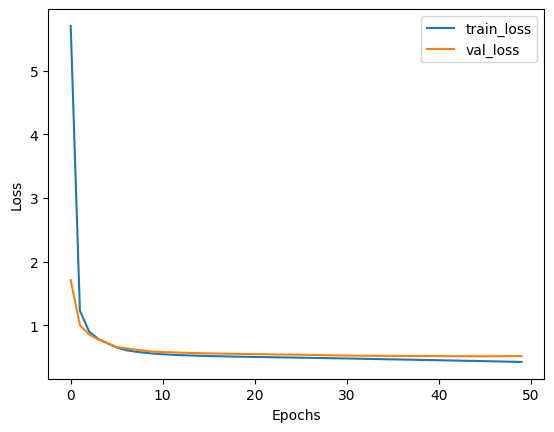

In [15]:
# Visualize training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Expectedly, the training accuracy was higher than the validation accuracy, but the difference was not large enough to imply any overfitting for the 50 epochs the model was run.

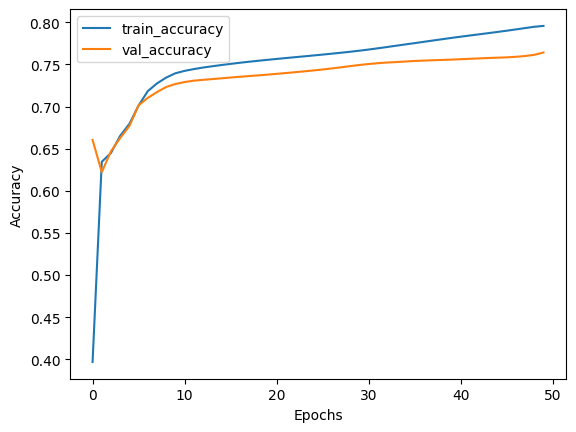

In [16]:
# Visualise training accuracy

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualisation of segmentation output and comparison with ground truth

We compare the segmentation output of our model against the ground truth. We place side-by-side the original image, the true mask as well as the predicted mask and visually similarity. For the 5 sampled images, the true masks and predicted masks were quite similar, though not perfectly so, as can be expected with real life data and modelling. However, it is quite satisfactory and implies that more hyperparameter tuning or model improvements may further increase the similarity. Nevertheless, the current model did not do very well on the second image, which may be due to other perculiarities of that particular image, among other factors.

2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step


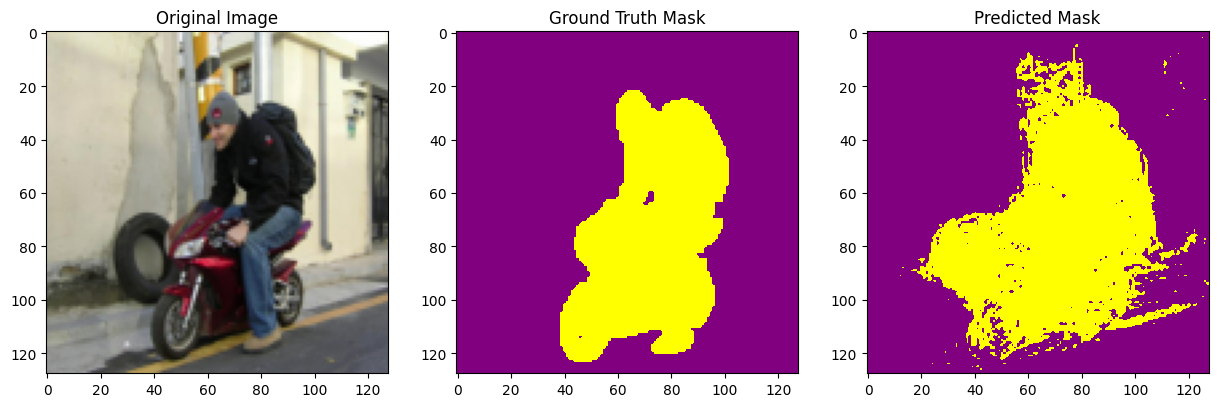

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


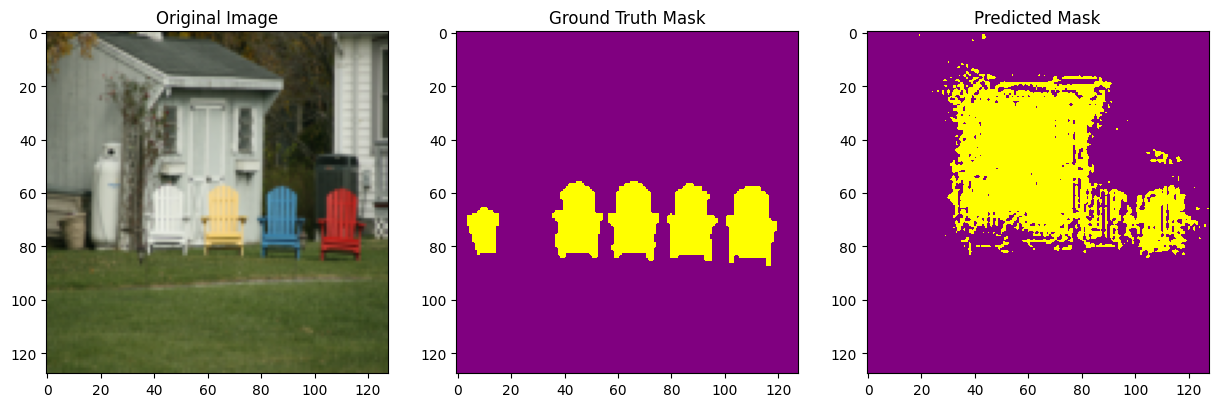

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


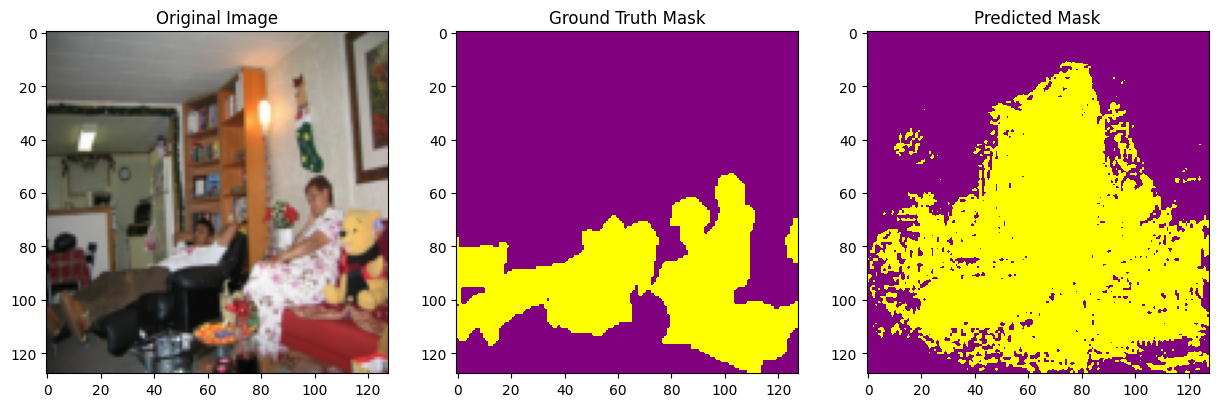

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


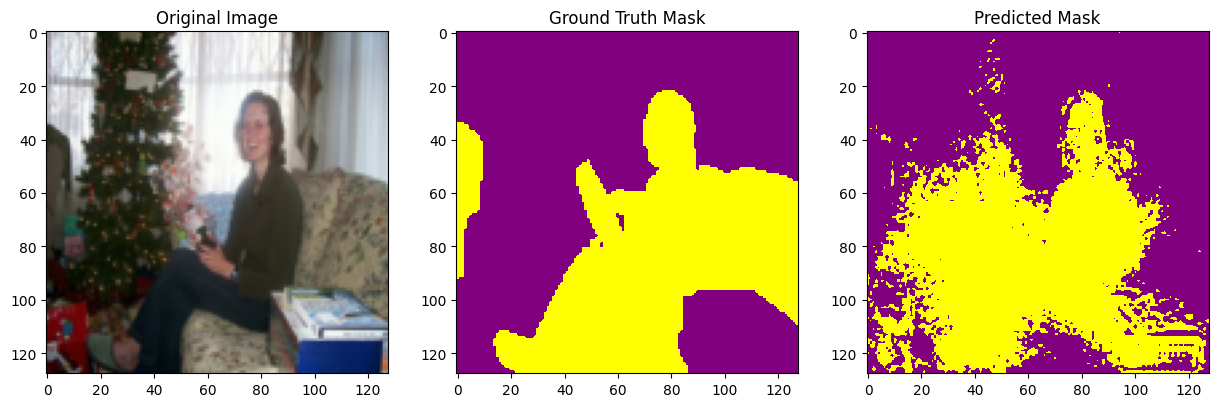

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


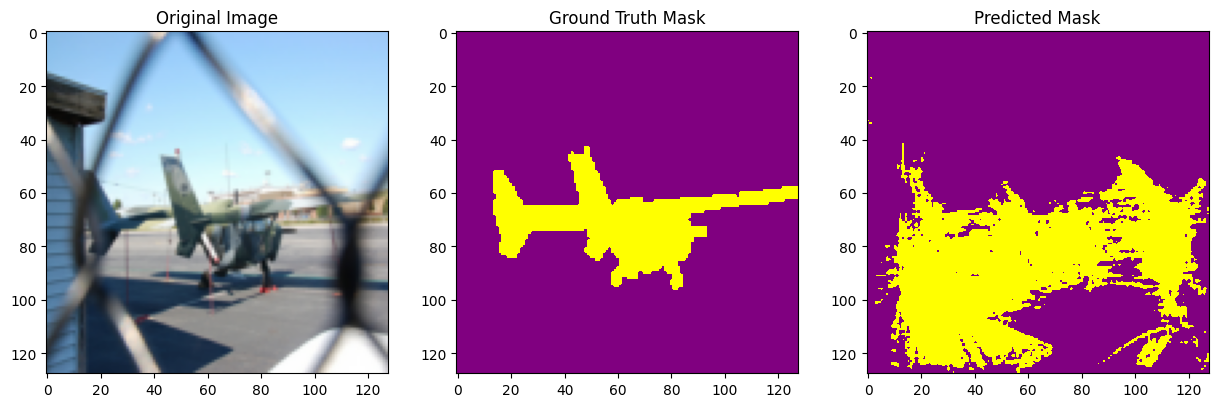

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom colormap
cmap_custom = plt.cm.colors.ListedColormap(['purple', 'yellow'])

# View predictions on some samples from the test dataset
num_predictions = 20
for i, sample in enumerate(test_ds.take(num_predictions)):
    image, mask = sample
    
    # Make predictions
    predictions = model.predict(image)
    
    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title('Original Image')
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].numpy(), cmap=cmap_custom)
    plt.title('Ground Truth Mask')
    
    # Predicted mask with custom colormap
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[0][:, :, 0], cmap=cmap_custom)
    plt.title('Predicted Mask')
    
    plt.show()

# Replace the Conv2DTranspose used to upsample with a bilinear interpolation using UpSampling2D followed by a standard convolution

In the model below, we replaced the Conv2DTranspose used to upsample with a bilinear interpolation using UpSampling2D followed by a standard convolution. The best epoch for this model was the 10th, out of the 50 that were set, with an validation accuracy of 76.08% and a validation loss of 0.4958. When compared to the first model which had an early stopping at the 46th out of 50 epochs, the current one stopped much earlier, which has implications on saving computational resources of various types, including early and therefore more preferable in terms of preserving the environment. We will compare the other metrics below.

In [19]:
# Upsample model

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def segmentation_upsample(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1_stride = tf.keras.layers.Conv2D(64, 3, strides=(2, 2), activation='relu', padding='same')(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv1_stride)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2_stride = tf.keras.layers.Conv2D(128, 3, strides=(2, 2), activation='relu', padding='same')(conv2)

    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv2_stride)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3_stride = tf.keras.layers.Conv2D(256, 3, strides=(2, 2), activation='relu', padding='same')(conv3)

    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv3_stride)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4_stride = tf.keras.layers.Conv2D(512, 3, strides=(2, 2), activation='relu', padding='same')(conv4)

    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv4_stride)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv4], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv3], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = tf.keras.layers.concatenate([up8, conv2], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = tf.keras.layers.concatenate([up9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model2 = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model2


_IMAGE_SHAPE = (128, 128)
_BATCH_SIZE = 64

# Compile the model
learning_rate = 0.0001
# model2 = segmentation_upsample(input_shape=(128, 128, 3))
model2 = segmentation_upsample(input_shape=(_IMAGE_SHAPE[0], _IMAGE_SHAPE[1], 3)) 


model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
               loss='binary_crossentropy', 
               metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('unet2_checkpoint.keras', monitor='val_loss', verbose=1, save_best_only=True)
]

# Train the model with callbacks
history2 = model2.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=callbacks)

# After training, you can load the saved weights from the best epoch
best_epoch_weights_path = 'unet2_checkpoint.keras'
model2.load_weights(best_epoch_weights_path)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6113 - loss: 1.0202
Epoch 1: val_loss improved from inf to 0.62029, saving model to unet2_checkpoint.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 45s 954ms/step - accuracy: 0.6126 - loss: 1.0130 - val_accuracy: 0.6928 - val_loss: 0.6203
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.7147 - loss: 0.5749
Epoch 2: val_loss improved from 0.62029 to 0.55760, saving model to unet2_checkpoint.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 806ms/step - accuracy: 0.7150 - loss: 0.5745 - val_accuracy: 0.7294 - val_loss: 0.5576
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.7469 - loss: 0.5248
Epoch 3: val_loss improved from 0.55760 to 0.53223, saving model to unet2_checkpoint.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 30s 799ms/step - accuracy: 0.7469 - loss: 0.5247 - val_accuracy: 0.7426 - val_loss: 0.5322
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.7539 - loss: 0.5079
Epoch 4: val_loss improved from 0

In [20]:
import warnings
import os

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress TensorFlow GPU allocation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Metrics

In this section, we focus on comparison of metrics for this model and the earlier one. We do not re-interpret the metrics again. This is because most metrics have more meaning in relative terms, when compared to those of other models, than just in themselves.

The table below summarises the metrics of the initial model against the second one with upsampling. It is clear that the second model performs much better in all the metrics presented in the table. Thus, the second model is better than the first one. Nevertheless, the improvements in accuracy, loss and other metrics are not very dramatic.

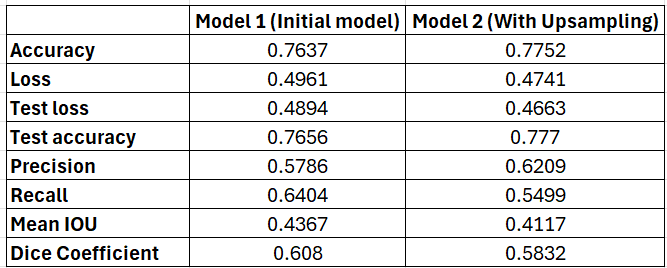

In [21]:
# Calculation of metrics

import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tensorflow.keras.optimizers import Adam

# Constants
_IMAGE_SHAPE = (128, 128)
_BATCH_SIZE = 64

# Custom functions for metrics
def compute_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    return intersection / union

def compute_dice_coefficient(y_true, y_pred):
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(tf.cast(y_true, tf.bool), tf.cast(y_pred, tf.bool)), tf.float32))
    return (2.0 * intersection) / (union + intersection)

# Evaluate the model on the test dataset
test_results = model2.evaluate(test_ds)

# Extract the metrics
test_loss = test_results[0]
test_accuracy = test_results[1]

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict on the test dataset
predictions = model2.predict(test_ds)

# Flatten the predictions and ground truth masks
predictions_flat = predictions.flatten()
y_test_flat = np.concatenate([y.numpy().flatten() for _, y in test_ds])

# Convert predictions to binary
predictions_binary = (predictions_flat > 0.5).astype(int)

# Compute precision, recall, and accuracy
precision = precision_score(y_test_flat, predictions_binary)
recall = recall_score(y_test_flat, predictions_binary)
accuracy = accuracy_score(y_test_flat, predictions_binary)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

# Compute IoU and Dice coefficient
iou = compute_iou(y_test_flat, predictions_binary)
dice_coefficient = compute_dice_coefficient(y_test_flat, predictions_binary)

print("IoU:", iou.numpy())
print("Dice Coefficient:", dice_coefficient.numpy())

# Compute mean IoU
mean_iou = np.mean(iou.numpy())
print("Mean IoU:", mean_iou)

5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7752 - loss: 0.4741 
Test Loss: 0.46625685691833496
Test Accuracy: 0.7770233154296875
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step
Precision: 0.6209460999539145
Recall: 0.5498570566712657
Accuracy: 0.7770233154296875
IoU: 0.41167507
Dice Coefficient: 0.58324337
Mean IoU: 0.41167507


The plot below shows the typical trajectory of the training and validation losses, where the validation loss is generally higher than the validation loss and has a convex shape. On the other hand, as expected, the training loss dramatically falls at first and then slows down over time. After epoch 10, the two lines diverge quite significantly, implying that you are likely to overfit after 10 epochs. Thus, the 10 epochs chosen by the callback in this model was the best.

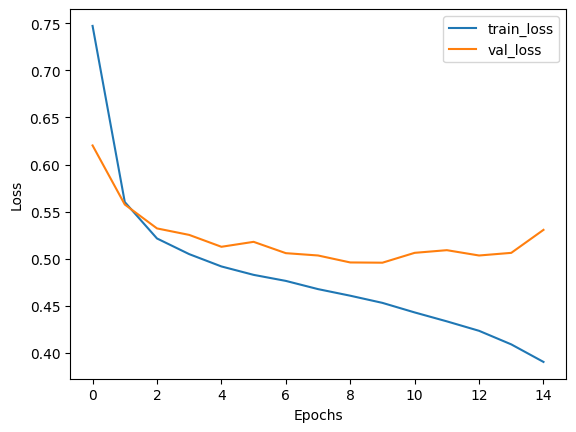

In [22]:
# Visualize training history
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The plot below compares the trajectory of the training and validation accuracies. This is in essence an inverted version of the above plot for training and validation loss. After epoch 10, the two lines diverge quite significantly, implying that you are likely to overfit after 10 epochs. Thus, the 10 epochs chosen by the callback in this model was the best.

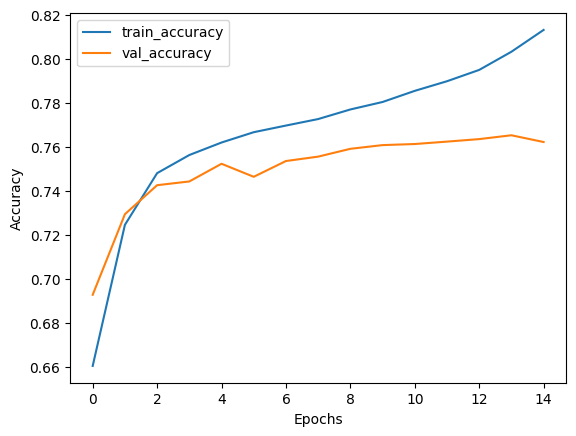

In [23]:
# Visualise training accuracy

plt.plot(history2.history['accuracy'], label='train_accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In this part, we make a visual comparison of the ground truth mask and the predicted mask to make a general assessment of how good our model was in the segmenting the images, compared to model 1 above. The visual difference in the predicted masks for the 2 models looks quite similar to the eye. It is relatively difficult to separate them. This may be due to the less than dramatic difference in the performance metrics of the two models. 

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step


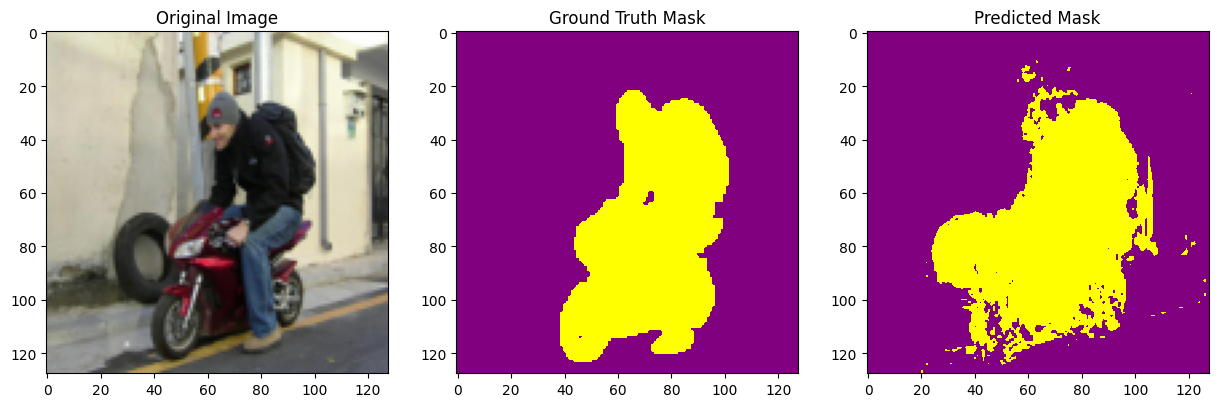

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


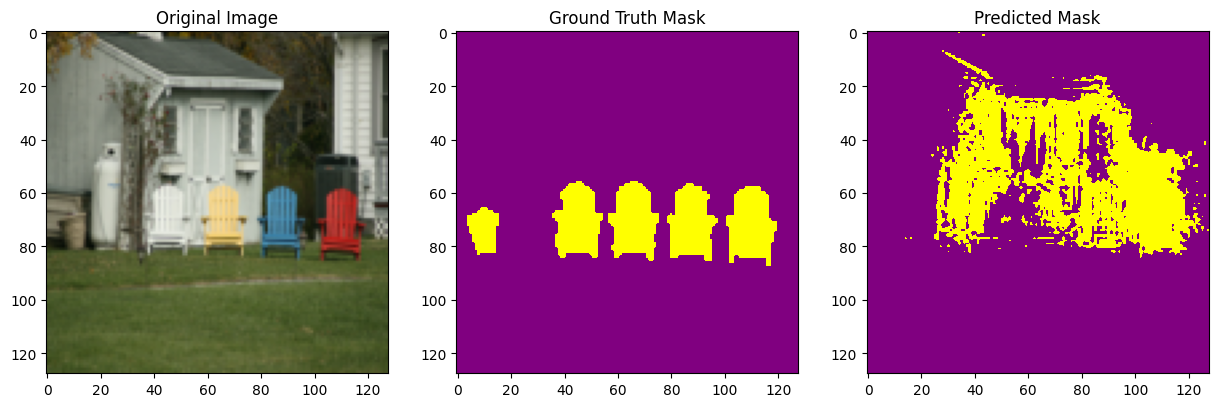

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


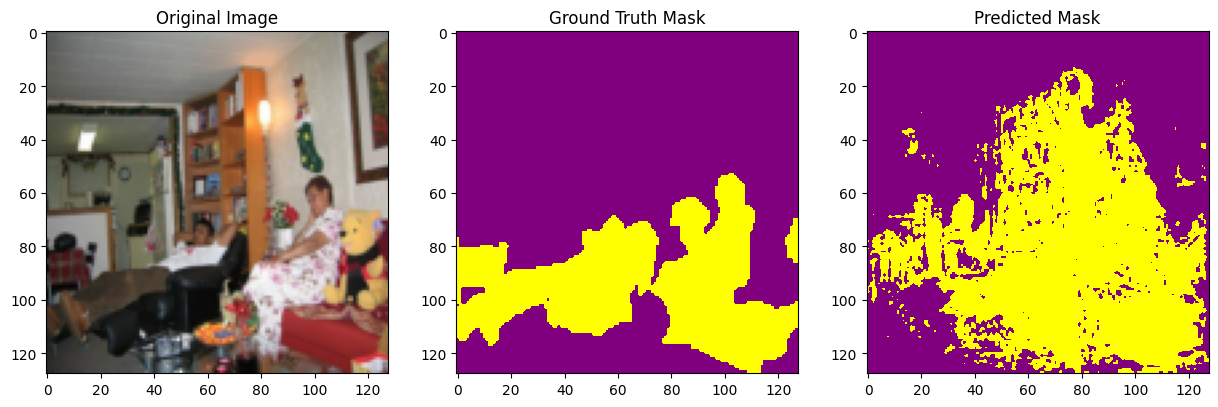

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


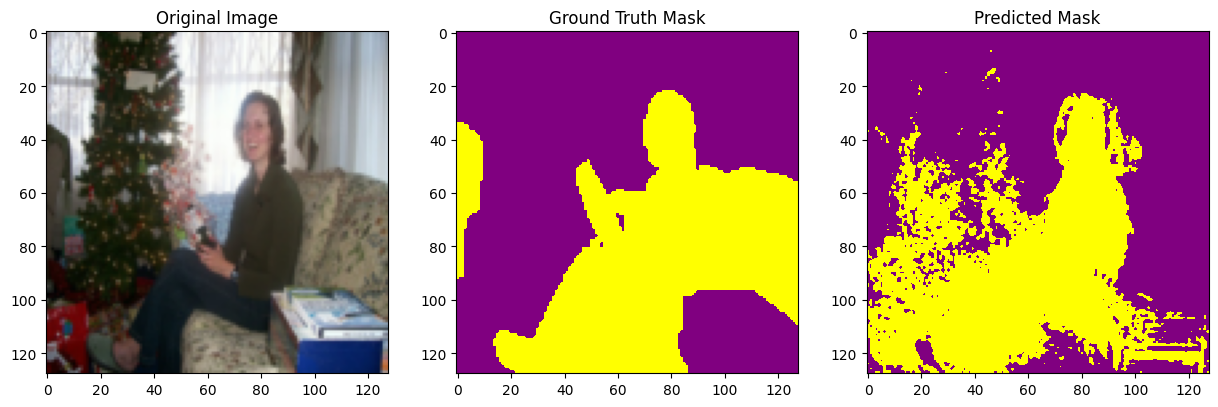

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step 


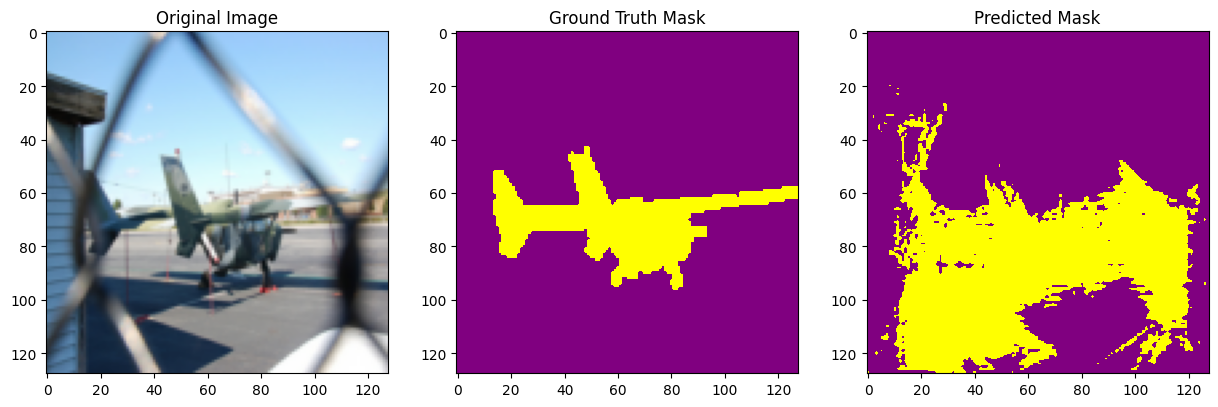

In [24]:
# Compare segmentation output versus ground truth

import matplotlib.pyplot as plt
import numpy as np

# Define custom colormap
cmap_custom = plt.cm.colors.ListedColormap(['purple', 'yellow'])

# View predictions on some samples from the test dataset
num_predictions = 20
for i, sample in enumerate(test_ds.take(num_predictions)):
    image, mask = sample
    
    # Make predictions
    predictions = model2.predict(image)
    
    # Plot original image, ground truth mask, and predicted mask
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title('Original Image')
    
    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask[0].numpy(), cmap=cmap_custom)
    plt.title('Ground Truth Mask')
    
    # Predicted mask with custom colormap
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[0][:, :, 0], cmap=cmap_custom)
    plt.title('Predicted Mask')
    
    plt.show()

## Conclusion

This was a very impressive "from scratch" segmentation model, with quite good performance metrics and quite similar ground truth and predicted masks for the two models that were fitted. Both models had accuracies in the range 75% - 77%. In terms of metrics, the second model was marginally better. Additionally, the second model obtained those metrics at 10 epochs when compared to the 46 epochs for the first models. I suppose that further model improvements (such as data augmentation, large sizes, larger batches etc, if time was available), could lead to a further 15% or more improvement in the metrics. Futhermore, if pre-trained models such as the Unet had been used, the performance would have been expected, given that those are trained on much larger datasets and have much more complex architectures, which can improve the segmentation without much overfitting.

# End of notebook